In [1]:
import matplotlib.pyplot as plt
import matplotlib
import datetime
import pandas as pd
import geopandas as gpd
import numpy as np

from src import download as D

In [2]:
downloader = D.downloader("./data")

# downloader.data_download("temperatures.csv", "https://stdatalake009.blob.core.windows.net/public/temperatures.csv")

In [3]:
dataset = pd.read_csv("./data/RAW/temperatures.csv")
dataset = dataset[["Region","Country","City","Month","Day","Year","AvgTemperature"]][dataset["Year"] != 2020]
dataset = dataset[["Region","Country","City","Month","Day","Year","AvgTemperature"]][dataset["Day"] != 0]
dataset = dataset[["Region","Country","City","Month","Day","Year","AvgTemperature"]][dataset["AvgTemperature"] != -99]
dataset["AvgTemperatureC"] = (dataset["AvgTemperature"]-32) * 5/9

# Analyse de la température moyenne en France de 1995 à 2019

In [4]:
dataset_france = dataset[["Month","Day","Year","AvgTemperatureC"]][dataset["Country"].str.contains("France")]

In [5]:
temp_moy_france = dataset_france.groupby(["Year"])["AvgTemperatureC"].mean()

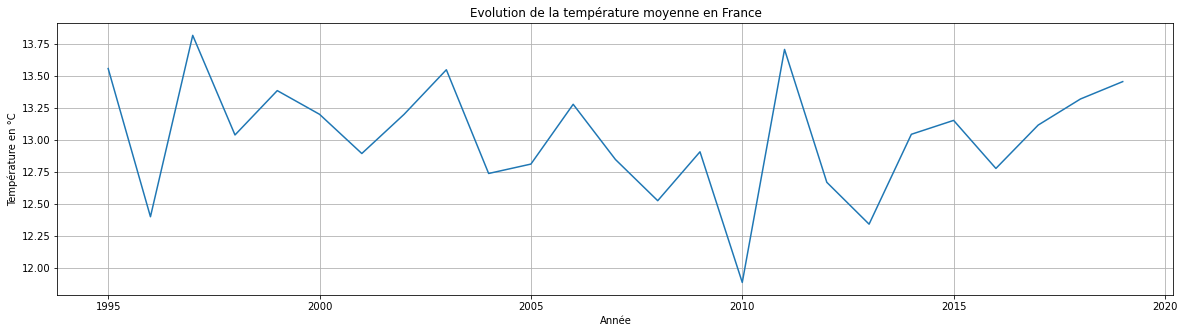

In [6]:
plt.figure(figsize=(20,5))
plt.plot(temp_moy_france) 
plt.title("Evolution de la température moyenne en France")
plt.ylabel("Température en °C")
plt.xlabel("Année")
plt.grid(True)

del dataset_france
del temp_moy_france

# Analyse de la température moyenne par mois et par région entre 1995 et 2019

In [7]:
dataset_moy = dataset.groupby(["Region","Month"])["AvgTemperatureC"].mean().reset_index()

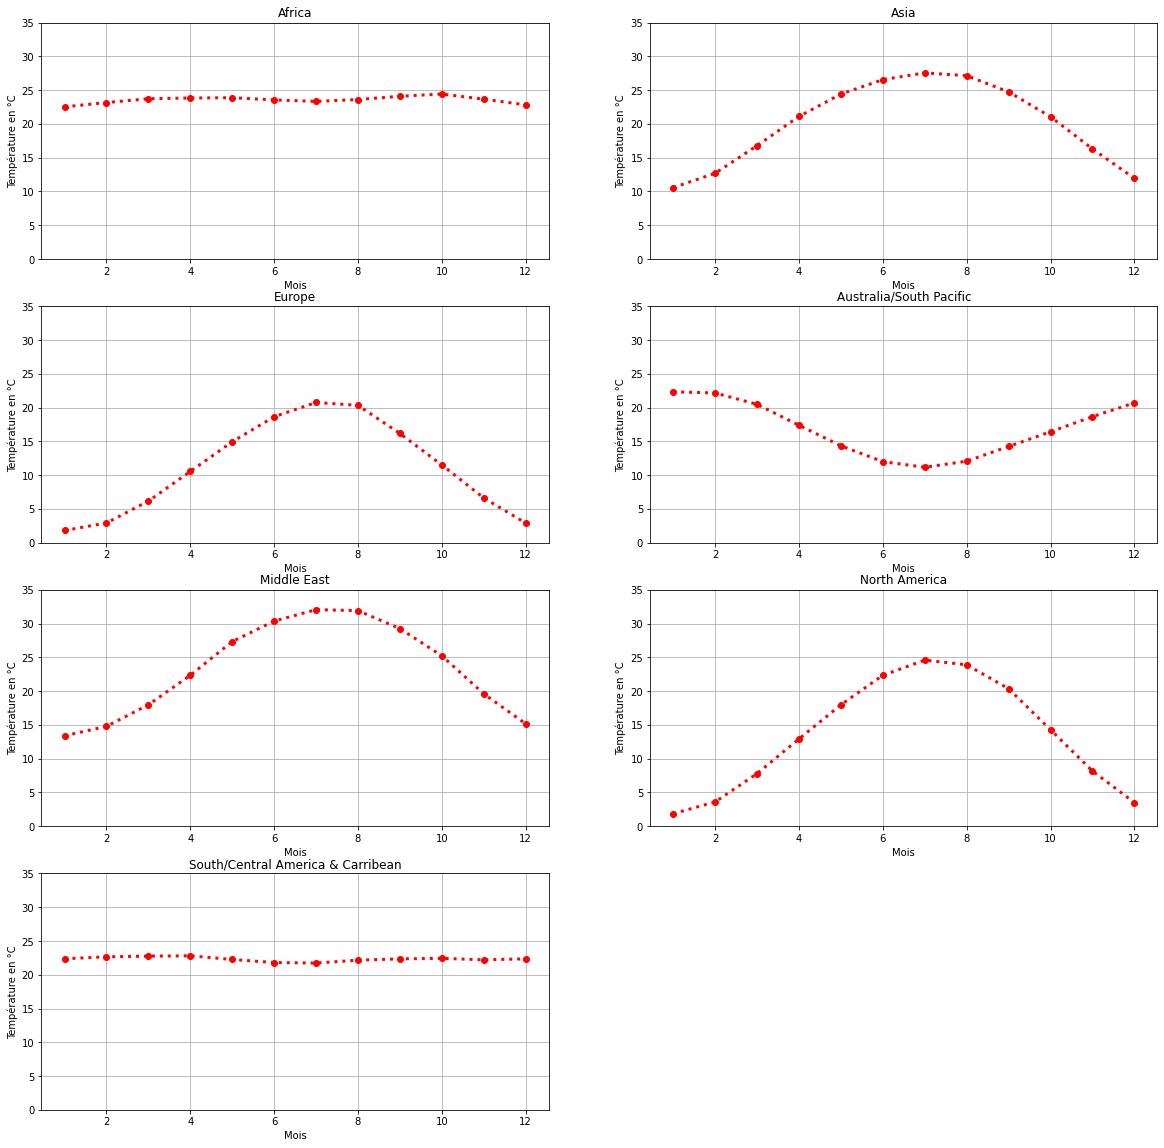

In [8]:
liste_regions = ["Africa","Asia", "Europe", "Australia/South Pacific", "Middle East", "North America", "South/Central America & Carribean"]
plt.figure(figsize=(20,20))

for i in range(len(liste_regions)):    
    plt.subplot(4,2,i+1)
    plt.plot(dataset_moy[["Month"]][dataset_moy["Region"].str.contains("Africa")], dataset_moy[["AvgTemperatureC"]][dataset_moy["Region"].str.contains(liste_regions[i])],c="red", lw=3, ls=":", marker="o")
    plt.title(liste_regions[i])
    plt.ylabel("Température en °C")
    plt.xlabel("Mois")
    plt.grid(True)
    plt.ylim(0,35)



del dataset_moy

# Classement des pays les plus chauds entre 1995 et 2019

In [9]:
dataset_top_chauds = dataset.groupby(["Country"])["AvgTemperatureC"].mean().sort_values(ascending=False).reset_index()

Text(0.5, 0, 'Pays')

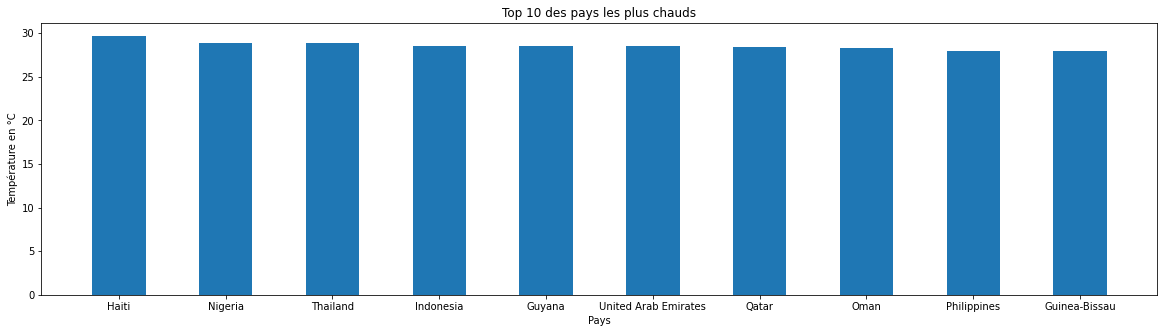

In [10]:
plt.figure(figsize=(20,5))
plt.bar(dataset_top_chauds["Country"][0:10], dataset_top_chauds["AvgTemperatureC"][0:10],  width=0.5)
plt.title("Top 10 des pays les plus chauds")
plt.ylabel("Température en °C")
plt.xlabel("Pays")

# Classement des pays les plus froids entre 1995 et 2019

In [11]:
dataset_top_froids = dataset.groupby(["Country"])["AvgTemperatureC"].mean().sort_values(ascending=True).reset_index()

Text(0.5, 0, 'Pays')

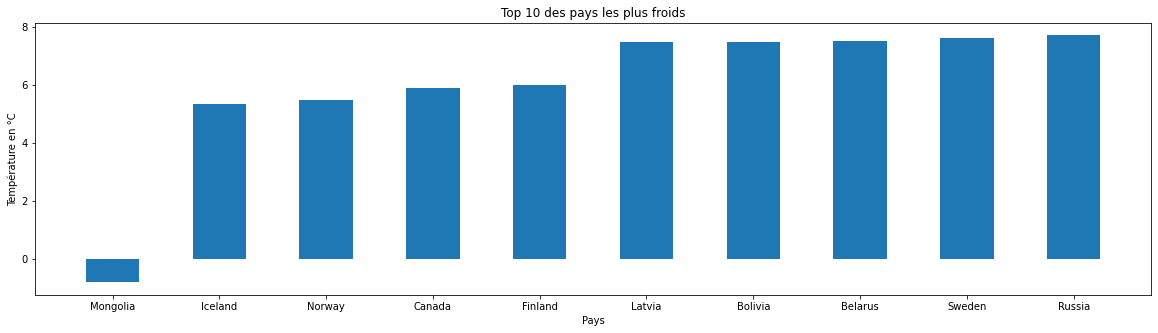

In [12]:
plt.figure(figsize=(20,5))
plt.bar(dataset_top_froids["Country"][0:10], dataset_top_froids["AvgTemperatureC"][0:10],  width=0.5)
plt.title("Top 10 des pays les plus froids")
plt.ylabel("Température en °C")
plt.xlabel("Pays")

# Evolution des températures entre le pays le plus froid et le pays le plus chaud, entre 1995 et 2019

In [13]:
data_froid = dataset[["Year", "AvgTemperatureC"]][dataset["Country"].str.contains(dataset_top_froids["Country"][0])].groupby(["Year"])["AvgTemperatureC"].mean().reset_index()
pays_froid = dataset_top_froids["Country"][0]
data_chaud = dataset[["Year", "AvgTemperatureC"]][dataset["Country"].str.contains(dataset_top_chauds["Country"][0])].groupby(["Year"])["AvgTemperatureC"].mean().reset_index()
pays_chaud = dataset_top_chauds["Country"][0]

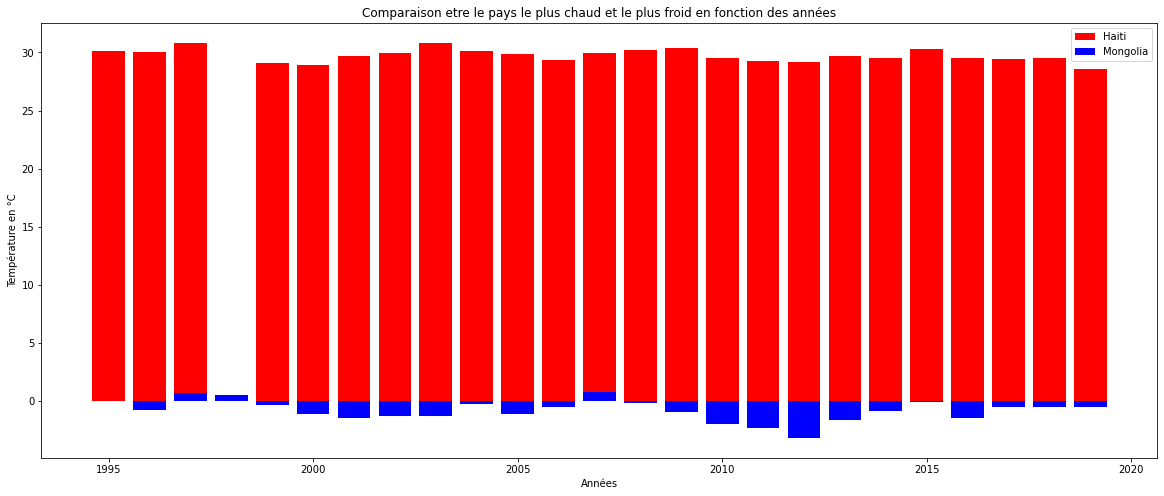

In [14]:
plt.figure(figsize=(20,8))
plt.bar(data_chaud["Year"], data_chaud["AvgTemperatureC"], color="red", label=pays_chaud)
plt.bar(data_froid["Year"], data_froid["AvgTemperatureC"], color="blue", label=pays_froid)
plt.legend()
plt.title("Comparaison etre le pays le plus chaud et le plus froid en fonction des années")
plt.ylabel("Température en °C")
plt.xlabel("Années")

del data_chaud, data_froid, pays_chaud, pays_froid, dataset_top_chauds, dataset_top_froids

# Evolution de la température de Paris

In [15]:
data_paris = dataset[["Month","Day","Year","AvgTemperatureC"]][dataset["City"].str.contains("Paris")]
data_paris[["Date"]] = pd.to_datetime((data_paris.Year*10000+data_paris.Month*100+data_paris.Day).apply(str),format='%Y%m%d')
data_paris[["Week number"]] = data_paris["Date"].dt.weekofyear + (52 * (data_paris["Year"] - 1995))
data_paris.drop(["Month", "Day"], inplace=True, axis=1)
data_moy_sem = data_paris.groupby(["Week number"])["AvgTemperatureC"].mean()

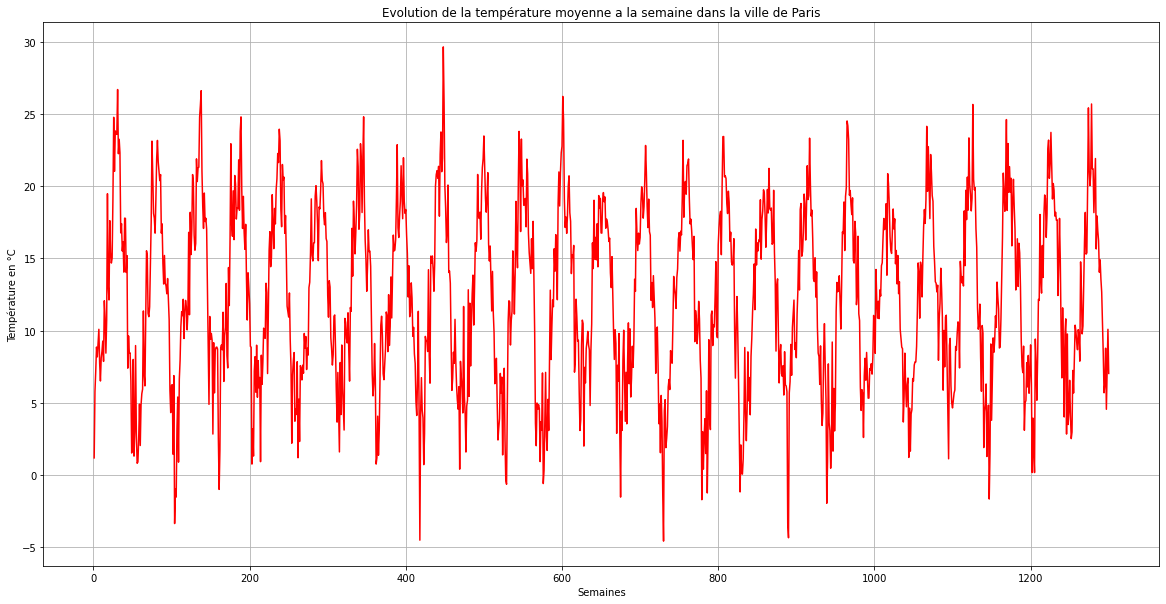

In [16]:
plt.figure(figsize=(20,10))
plt.plot(data_moy_sem, c="red")
plt.title("Evolution de la température moyenne a la semaine dans la ville de Paris")
plt.ylabel("Température en °C")
plt.xlabel("Semaines")
plt.grid(True)

del data_paris, data_moy_sem

# La carte de ses morts


In [17]:
plt.style.use('seaborn')

In [18]:
dataset2010 = dataset[["Region","Country","City","Month","Day","Year","AvgTemperatureC"]][dataset["Year"] > 2009]

In [19]:
data_moy_pays = dataset2010.groupby(["Country"])["AvgTemperatureC"].mean()

In [20]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap = worldmap.replace(to_replace ="United States of America", value ="US")

worldmap.rename(columns={"name" : "Country"}, inplace=True)

worldmap.set_index("Country", inplace=True)

In [21]:
worldmap_with_data = worldmap.join(data_moy_pays).reset_index()

<AxesSubplot:>

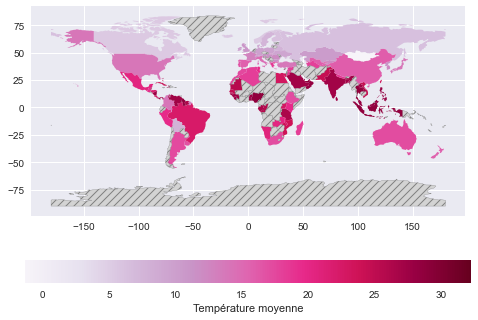

In [23]:
worldmap_with_data.plot(column="AvgTemperatureC", legend=True, cmap='PuRd', missing_kwds={"color": "lightgrey","edgecolor": "grey","hatch": "///","label": "Missing values"}, legend_kwds={'label': "Température moyenne", 'orientation': "horizontal"})